# Multi-Objective Portfolio Optimization - 3-Parameter Grid Search

This notebook provides flexible optimization for various objectives using a comprehensive 3-parameter grid search:

**Optimization Parameters:**
1. **Drawdown Filter Lookback**: 3-180 days (10 values)
2. **Drawdown Filter Threshold**: 1%-10% (10 values) 
3. **Leverage Multiplier**: 1.0x-10.0x (11 values)

**Total Combinations**: 10 × 10 × 11 = **1,100 parameter combinations**

**Available Objectives**:
- **Min Drawdown**: Find the most linear and stable equity curves
- **Max Total Return**: Find the highest absolute returns regardless of risk

Choose your optimization objective in the configuration cell below.

In [1]:
# =============================================================================
# OPTIMIZATION OBJECTIVE CONFIGURATION - CHOOSE YOUR TARGET
# =============================================================================

# 🎯 SELECT YOUR OPTIMIZATION OBJECTIVE:
# Options: 'min_drawdown', 'max_return'

OPTIMIZATION_OBJECTIVE = 'max_return'  # ⬅️ CHANGE THIS TO SWITCH OBJECTIVES

# Objective descriptions:
optimization_config = {
    'min_drawdown': {
        'title': 'Minimum Drawdown Optimization',
        'description': 'Find the most linear and stable equity curves',
        'target_metric': 'max_drawdown_pct',
        'ascending': False,  # Less negative = better
        'best_label': 'Lowest Drawdown',
        'improvement_direction': 'reduced'
    },
    'max_return': {
        'title': 'Maximum Total Return Optimization', 
        'description': 'Find the highest absolute returns regardless of risk',
        'target_metric': 'total_return_pct',
        'ascending': False,  # Higher = better
        'best_label': 'Highest Return',
        'improvement_direction': 'increased'
    }
}

# Get current configuration
config = optimization_config[OPTIMIZATION_OBJECTIVE]

print(f"🎯 SELECTED OBJECTIVE: {config['title']}")
print(f"📋 Description: {config['description']}")
print(f"📊 Target metric: {config['target_metric']}")
print(f"🏆 Ranking: {config['best_label']}")
print("=" * 60)

🎯 SELECTED OBJECTIVE: Maximum Total Return Optimization
📋 Description: Find the highest absolute returns regardless of risk
📊 Target metric: total_return_pct
🏆 Ranking: Highest Return


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import warnings
import itertools
from tqdm.notebook import tqdm
import seaborn as sns

warnings.filterwarnings('ignore')

# Add drawdown filter module path
sys.path.append('../')
from drawdown_filter import (
    apply_drawdown_filter,
    calculate_filter_performance
)

# Set plotting parameters
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.formatter.limits'] = [-3, 3]
sns.set_style("whitegrid")

print(f"📊 {config['title']} - 3-Parameter Grid Search")
print("=" * 60)

📊 Maximum Total Return Optimization - 3-Parameter Grid Search


## 1. Load Data and Create Equal Weight Portfolio

In [3]:
def clean_data(df):
    """Clean data from infinites and NaN values"""
    df_clean = df.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.fillna(method='ffill')
    df_clean = df_clean.fillna(0)
    
    # Final check for non-finite values
    mask = ~np.isfinite(df_clean.values)
    if mask.any():
        df_clean = df_clean.mask(mask, 0)
    
    return df_clean

# Load commodity futures results
results_dir = Path('../data/results')

# Load equity curves for individual strategies
equity_curves = pd.read_parquet(results_dir / 'all_equity_curves.parquet')
equity_curves = clean_data(equity_curves)

print(f"📈 Loaded {equity_curves.shape[1]} commodity futures strategies")
print(f"📅 Date range: {equity_curves.index.min().strftime('%Y-%m-%d')} to {equity_curves.index.max().strftime('%Y-%m-%d')}")
print(f"📋 Strategy tickers: {list(equity_curves.columns)}")
print(f"🗓️  Trading days: {len(equity_curves)} days")

# Calculate actual time period for CAGR calculations
start_date = equity_curves.index[0]
end_date = equity_curves.index[-1]
actual_years = (end_date - start_date).days / 365.25
print(f"⏰ Actual period: {actual_years:.1f} years")

# Create Equal Weight Portfolio Base (without leverage)
# Convert equity curves (cumulative returns) to price series starting at 1
equity_prices = 1 + equity_curves  # From cumulative returns to prices

# Calculate daily returns for each strategy
daily_returns = equity_prices.pct_change().fillna(0)

# Equal weight portfolio: simple average of daily returns
base_equal_weight_returns = daily_returns.mean(axis=1)
base_equal_weight_equity = (1 + base_equal_weight_returns).cumprod()

print(f"\n📊 BASE EQUAL WEIGHT PORTFOLIO (No Leverage):")
print(f"   • Final equity value: {base_equal_weight_equity.iloc[-1]:.4f}")
print(f"   • Total return: {(base_equal_weight_equity.iloc[-1] - 1.0)*100:.2f}%")

# Calculate base performance metrics
base_returns_clean = base_equal_weight_returns.dropna()
if len(base_returns_clean) > 0:
    base_annual_return = base_returns_clean.mean() * 252 * 100
    base_volatility = base_returns_clean.std() * np.sqrt(252) * 100
    base_sharpe = (base_returns_clean.mean() * 252) / (base_returns_clean.std() * np.sqrt(252)) if base_returns_clean.std() > 0 else 0
    
    # Calculate max drawdown
    running_max = base_equal_weight_equity.expanding().max()
    drawdown = (base_equal_weight_equity - running_max) / running_max
    base_max_drawdown = drawdown.min() * 100
    
    print(f"   • Annualized return: {base_annual_return:.2f}%")
    print(f"   • Annualized volatility: {base_volatility:.2f}%")
    print(f"   • Sharpe ratio: {base_sharpe:.3f}")
    print(f"   • Max drawdown: {base_max_drawdown:.1f}%")

📈 Loaded 15 commodity futures strategies
📅 Date range: 2010-01-04 to 2025-08-08
📋 Strategy tickers: ['CL=F', 'NG=F', 'BZ=F', 'RB=F', 'HO=F', 'GC=F', 'SI=F', 'HG=F', 'PA=F', 'ZC=F', 'ZW=F', 'ZS=F', 'SB=F', 'CT=F', 'CC=F']
🗓️  Trading days: 5696 days
⏰ Actual period: 15.6 years

📊 BASE EQUAL WEIGHT PORTFOLIO (No Leverage):
   • Final equity value: 1.8865
   • Total return: 88.65%
   • Annualized return: 3.13%
   • Annualized volatility: 7.96%
   • Sharpe ratio: 0.393
   • Max drawdown: -27.7%


## 2. 3-Parameter Grid Search Configuration

In [4]:
# =============================================================================
# 3-PARAMETER OPTIMIZATION GRID CONFIGURATION
# =============================================================================

# Define the 3-parameter space for optimization
OPTIMIZATION_PARAMS = {
    # Drawdown filter lookback periods (days)
    'lookback_days': [3,5,7,14,30, 60, 90, 120, 150, 180],
    
    # Drawdown filter thresholds (as decimals)
    'threshold_pct': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10],  # 1% to 10%
    
    # Leverage multipliers
    'leverage': [1]
}

# Calculate total combinations
total_combinations = (
    len(OPTIMIZATION_PARAMS['lookback_days']) * 
    len(OPTIMIZATION_PARAMS['threshold_pct']) * 
    len(OPTIMIZATION_PARAMS['leverage'])
)

print("🎯 3-PARAMETER GRID SEARCH CONFIGURATION:")
print(f"   • Lookback periods: {OPTIMIZATION_PARAMS['lookback_days']} days ({len(OPTIMIZATION_PARAMS['lookback_days'])} values)")
print(f"   • Filter thresholds: {[f'{t*100:.0f}%' for t in OPTIMIZATION_PARAMS['threshold_pct']]} ({len(OPTIMIZATION_PARAMS['threshold_pct'])} values)")
print(f"   • Leverage levels: {[f'{l:.1f}x' for l in OPTIMIZATION_PARAMS['leverage']]} ({len(OPTIMIZATION_PARAMS['leverage'])} values)")
print(f"   • Total combinations: {total_combinations}")
print(f"   • Optimization target: {config['best_label']}")

print(f"\n⚡ Estimated runtime: ~{total_combinations * 0.1:.0f} seconds")

🎯 3-PARAMETER GRID SEARCH CONFIGURATION:
   • Lookback periods: [3, 5, 7, 14, 30, 60, 90, 120, 150, 180] days (10 values)
   • Filter thresholds: ['1%', '2%', '3%', '4%', '5%', '6%', '7%', '8%', '9%', '10%'] (10 values)
   • Leverage levels: ['1.0x'] (1 values)
   • Total combinations: 100
   • Optimization target: Highest Return

⚡ Estimated runtime: ~10 seconds


## 3. Grid Search Execution Functions

In [5]:
def apply_leverage_with_constraints(returns, leverage):
    """Apply leverage to returns with realistic daily loss cap"""
    if leverage == 1.0:
        return returns
    
    # Apply leverage to returns
    leveraged_returns = returns * leverage
    
    # CRITICAL: Cap daily losses to -99% to prevent negative equity
    max_daily_loss = -0.99
    leveraged_returns = leveraged_returns.clip(lower=max_daily_loss)
    
    return leveraged_returns

def calculate_performance_metrics(equity_curve, returns_series):
    """Calculate comprehensive performance metrics"""
    # Basic metrics
    total_return = (equity_curve.iloc[-1] / equity_curve.iloc[0] - 1) * 100
    annual_return = returns_series.mean() * 252 * 100
    volatility = returns_series.std() * np.sqrt(252) * 100
    sharpe_ratio = (returns_series.mean() * 252) / (returns_series.std() * np.sqrt(252)) if returns_series.std() > 0 else 0
    
    # Drawdown metrics
    running_max = equity_curve.expanding().max()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    avg_drawdown = drawdown.mean() * 100
    
    # CAGR using actual dates
    start_date = equity_curve.index[0]
    end_date = equity_curve.index[-1]
    n_years = (end_date - start_date).days / 365.25
    
    if n_years > 0 and equity_curve.iloc[0] != 0:
        cagr = ((equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/n_years) - 1) * 100
    else:
        cagr = 0
    
    return {
        'total_return_pct': total_return,
        'cagr_pct': cagr,
        'annual_return_pct': annual_return,
        'volatility_pct': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown_pct': max_drawdown,
        'avg_drawdown_pct': avg_drawdown
    }

def run_single_combination(base_returns, lookback, threshold, leverage):
    """Run optimization for a single parameter combination"""
    try:
        # Step 1: Apply leverage with constraints
        leveraged_returns = apply_leverage_with_constraints(base_returns, leverage)
        leveraged_equity = (1 + leveraged_returns).cumprod()
        
        # Step 2: Apply drawdown filter
        filter_df = apply_drawdown_filter(
            leveraged_equity, 
            leveraged_returns,
            lookback,
            threshold
        )
        
        # Step 3: Calculate performance metrics
        filtered_returns = filter_df['filtered_equity'].pct_change().dropna()
        if len(filtered_returns) == 0:
            return None
            
        metrics = calculate_performance_metrics(filter_df['filtered_equity'], filtered_returns)
        
        # Step 4: Calculate filter statistics
        filter_active_time = (filter_df['can_trade_lagged'].sum() / len(filter_df)) * 100
        filter_changes = filter_df['can_trade_lagged'].diff().abs().sum()
        
        # Step 5: Package results
        result = {
            'lookback_days': lookback,
            'threshold_pct': threshold * 100,
            'leverage': leverage,
            'sharpe_ratio': metrics['sharpe_ratio'],
            'total_return_pct': metrics['total_return_pct'],
            'cagr_pct': metrics['cagr_pct'],
            'annual_return_pct': metrics['annual_return_pct'],
            'volatility_pct': metrics['volatility_pct'],
            'max_drawdown_pct': metrics['max_drawdown_pct'],
            'avg_drawdown_pct': metrics['avg_drawdown_pct'],
            'filter_active_time_pct': filter_active_time,
            'filter_changes': filter_changes,
            'filtered_equity': filter_df['filtered_equity'],
            'filter_signal': filter_df['can_trade_lagged'].astype(int)
        }
        
        return result
        
    except Exception as e:
        print(f"❌ Error with lookback={lookback}, threshold={threshold:.1%}, leverage={leverage:.1f}x: {e}")
        return None

print("✅ Optimization functions defined")

✅ Optimization functions defined


## 4. Execute 3-Parameter Grid Search

In [6]:
# =============================================================================
# EXECUTE COMPREHENSIVE 3-PARAMETER GRID SEARCH
# =============================================================================

print(f"🚀 STARTING 3-PARAMETER GRID SEARCH ({config['title'].upper()})")
print("=" * 60)
print(f"Processing {total_combinations} parameter combinations...")
print(f"Target: {config['description']}")

# Generate all parameter combinations
all_combinations = list(itertools.product(
    OPTIMIZATION_PARAMS['lookback_days'],
    OPTIMIZATION_PARAMS['threshold_pct'], 
    OPTIMIZATION_PARAMS['leverage']
))

print(f"Generated {len(all_combinations)} combinations")

# Execute grid search with progress tracking
optimization_results = []
failed_combinations = 0

# Use tqdm for progress tracking
for lookback, threshold, leverage in tqdm(all_combinations, desc="Optimizing", unit="combo"):
    result = run_single_combination(base_equal_weight_returns, lookback, threshold, leverage)
    
    if result is not None:
        optimization_results.append(result)
    else:
        failed_combinations += 1

print(f"\n✅ Grid search completed!")
print(f"   • Successful combinations: {len(optimization_results)}")
print(f"   • Failed combinations: {failed_combinations}")
print(f"   • Success rate: {len(optimization_results)/total_combinations*100:.1f}%")

🚀 STARTING 3-PARAMETER GRID SEARCH (MAXIMUM TOTAL RETURN OPTIMIZATION)
Processing 100 parameter combinations...
Target: Find the highest absolute returns regardless of risk
Generated 100 combinations


Optimizing:   0%|          | 0/100 [00:00<?, ?combo/s]


✅ Grid search completed!
   • Successful combinations: 100
   • Failed combinations: 0
   • Success rate: 100.0%


## 5. Rank Results and Identify Top Combinations

In [7]:
# Convert results to DataFrame and sort by selected objective
if len(optimization_results) > 0:
    # Create results DataFrame (excluding equity series for now)
    results_metrics = []
    equity_series_storage = {}
    
    for i, result in enumerate(optimization_results):
        # Store equity series separately
        combo_key = f"combo_{i}"
        equity_series_storage[combo_key] = {
            'filtered_equity': result['filtered_equity'],
            'filter_signal': result['filter_signal']
        }
        
        # Store metrics
        metrics = {k: v for k, v in result.items() if k not in ['filtered_equity', 'filter_signal']}
        metrics['combo_key'] = combo_key
        results_metrics.append(metrics)
    
    # Sort by selected objective metric
    results_df = pd.DataFrame(results_metrics)
    target_metric = config['target_metric']
    ascending = config['ascending']
    
    results_df = results_df.sort_values(target_metric, ascending=ascending).reset_index(drop=True)
    results_df['rank'] = range(1, len(results_df) + 1)
    
    print(f"🏆 TOP 10 PARAMETER COMBINATIONS (Ranked by {config['best_label']}):")
    print("=" * 70)
    
    # Dynamic column ordering based on objective
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        cols = ['rank', 'lookback_days', 'threshold_pct', 'leverage', 'max_drawdown_pct',
                'sharpe_ratio', 'total_return_pct', 'cagr_pct', 'filter_active_time_pct']
    else:  # max_return
        cols = ['rank', 'lookback_days', 'threshold_pct', 'leverage', 'total_return_pct',
                'cagr_pct', 'sharpe_ratio', 'max_drawdown_pct', 'filter_active_time_pct']
    
    top_10 = results_df.head(10)[cols].round(4)
    print(top_10.to_string(index=False))
    
    # Get the absolute best combination
    best_combo = results_df.iloc[0]
    print(f"\n🥇 BEST COMBINATION ({config['best_label']}):")
    print(f"   • Parameters: {best_combo['lookback_days']:.0f} days lookback, {best_combo['threshold_pct']:.0f}% threshold, {best_combo['leverage']:.1f}x leverage")
    
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        print(f"   • Max Drawdown: {best_combo['max_drawdown_pct']:.1f}% (BEST)")
        print(f"   • Total Return: {best_combo['total_return_pct']:.2f}%")
        print(f"   • Sharpe Ratio: {best_combo['sharpe_ratio']:.4f}")
    else:  # max_return
        print(f"   • Total Return: {best_combo['total_return_pct']:.2f}% (BEST)")
        print(f"   • CAGR: {best_combo['cagr_pct']:.2f}%")
        print(f"   • Max Drawdown: {best_combo['max_drawdown_pct']:.1f}%")
        print(f"   • Sharpe Ratio: {best_combo['sharpe_ratio']:.4f}")
    
    print(f"   • Filter Active: {best_combo['filter_active_time_pct']:.1f}% of time")
    
else:
    print("❌ No valid results found from grid search!")
    results_df = pd.DataFrame()

🏆 TOP 10 PARAMETER COMBINATIONS (Ranked by Highest Return):
 rank  lookback_days  threshold_pct  leverage  total_return_pct  cagr_pct  sharpe_ratio  max_drawdown_pct  filter_active_time_pct
    1             60            8.0         1          102.3968    4.6257        0.4908          -18.4588                 97.9810
    2             60           10.0         1          102.2879    4.6221        0.4805          -16.4876                 98.9291
    3            150            6.0         1           99.9485    4.5441        0.5141          -18.2221                 88.3954
    4             60            7.0         1           98.1042    4.4820        0.4796          -22.0963                 97.3490
    5            180            6.0         1           98.0233    4.4792        0.5145          -18.2221                 85.8322
    6             90            9.0         1           96.8493    4.4394        0.4707          -17.0004                 97.8230
    7            120          

## 6. Detailed Analysis of Top Combinations

In [8]:
# =============================================================================
# PREPARE TOP COMBINATIONS FOR DETAILED ANALYSIS
# =============================================================================

if len(results_df) > 0:
    # Select top 5 combinations for detailed analysis
    TOP_N = 5
    top_combinations = results_df.head(TOP_N)
    
    print(f"📊 DETAILED ANALYSIS OF TOP {TOP_N} COMBINATIONS:")
    print("=" * 60)
    
    # Prepare data for plotting and analysis
    top_combinations_data = {}
    
    for idx, row in top_combinations.iterrows():
        combo_key = row['combo_key']
        
        # Dynamic label based on objective
        if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
            metric_label = f"MaxDD: {row['max_drawdown_pct']:.1f}%"
        else:  # max_return
            metric_label = f"Return: {row['total_return_pct']:.1f}%"
            
        label = f"Rank_{row['rank']}: {row['lookback_days']:.0f}d, {row['threshold_pct']:.0f}%, {row['leverage']:.1f}x ({metric_label})"
        
        # Store combination data
        top_combinations_data[label] = {
            'params': {
                'lookback': row['lookback_days'],
                'threshold': row['threshold_pct'] / 100,  # Convert back to decimal
                'leverage': row['leverage']
            },
            'metrics': row.to_dict(),
            'equity_curve': equity_series_storage[combo_key]['filtered_equity'],
            'filter_signal': equity_series_storage[combo_key]['filter_signal']
        }
        
        print(f"{row['rank']}. {label}")
        if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
            print(f"    → Max DD: {row['max_drawdown_pct']:.1f}% | Sharpe: {row['sharpe_ratio']:.3f} | Total Return: {row['total_return_pct']:.2f}%")
        else:  # max_return
            print(f"    → Total Return: {row['total_return_pct']:.2f}% | CAGR: {row['cagr_pct']:.2f}% | Max DD: {row['max_drawdown_pct']:.1f}%")
        print(f"    → Filter Active: {row['filter_active_time_pct']:.1f}% | Volatility: {row['volatility_pct']:.2f}%")
        print()
    
    print(f"✅ Prepared {len(top_combinations_data)} combinations for visualization")
    
else:
    top_combinations_data = {}
    print("❌ No combinations available for analysis")

📊 DETAILED ANALYSIS OF TOP 5 COMBINATIONS:
1. Rank_1: 60d, 8%, 1.0x (Return: 102.4%)
    → Total Return: 102.40% | CAGR: 4.63% | Max DD: -18.5%
    → Filter Active: 98.0% | Volatility: 6.83%

2. Rank_2: 60d, 10%, 1.0x (Return: 102.3%)
    → Total Return: 102.29% | CAGR: 4.62% | Max DD: -16.5%
    → Filter Active: 98.9% | Volatility: 7.00%

3. Rank_3: 150d, 6%, 1.0x (Return: 99.9%)
    → Total Return: 99.95% | CAGR: 4.54% | Max DD: -18.2%
    → Filter Active: 88.4% | Volatility: 6.36%

4. Rank_4: 60d, 7%, 1.0x (Return: 98.1%)
    → Total Return: 98.10% | CAGR: 4.48% | Max DD: -22.1%
    → Filter Active: 97.3% | Volatility: 6.79%

5. Rank_5: 180d, 6%, 1.0x (Return: 98.0%)
    → Total Return: 98.02% | CAGR: 4.48% | Max DD: -18.2%
    → Filter Active: 85.8% | Volatility: 6.26%

✅ Prepared 5 combinations for visualization


## 7. Equity Curves Visualization

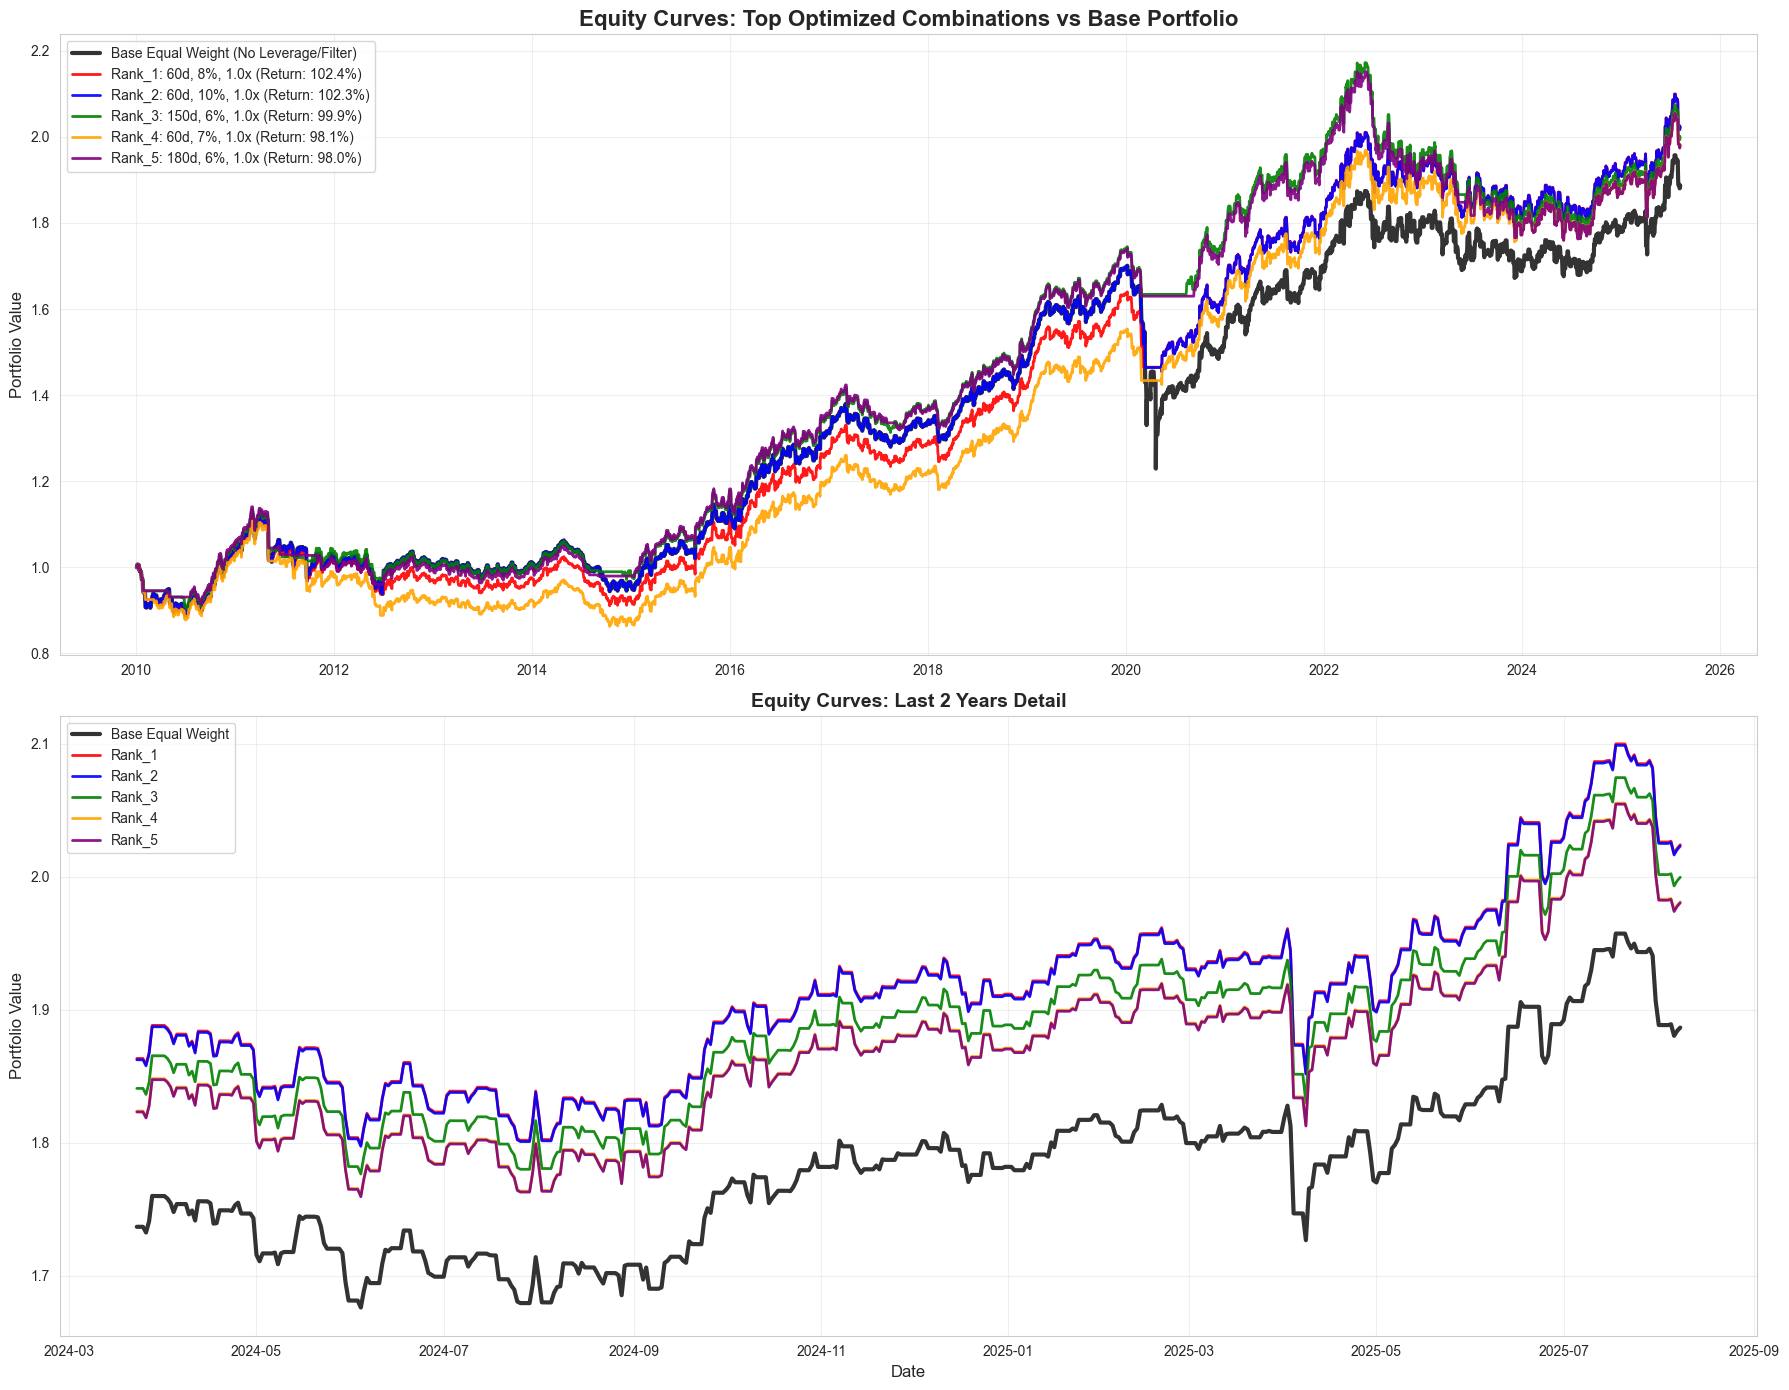


📈 PERFORMANCE COMPARISON TABLE:
                               Strategy  Sharpe  Total Return %  CAGR %  Max DD %  Volatility %
              Base (No Leverage/Filter)   0.393          88.649   4.155   -27.713         7.964
 Rank_1: 60d, 8%, 1.0x (Return: 102.4%)   0.491         102.397   4.626   -18.459         6.832
Rank_2: 60d, 10%, 1.0x (Return: 102.3%)   0.481         102.288   4.622   -16.488         6.998
 Rank_3: 150d, 6%, 1.0x (Return: 99.9%)   0.514          99.948   4.544   -18.222         6.357
  Rank_4: 60d, 7%, 1.0x (Return: 98.1%)   0.480          98.104   4.482   -22.096         6.788
 Rank_5: 180d, 6%, 1.0x (Return: 98.0%)   0.515          98.023   4.479   -18.222         6.256


In [9]:
# =============================================================================
# EQUITY CURVES COMPARISON PLOTS
# =============================================================================

if len(top_combinations_data) > 0:
    
    # Plot 1: All Top Combinations vs Base
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
    
    # Top plot: Full period comparison
    ax1.plot(base_equal_weight_equity.index, base_equal_weight_equity.values,
             label='Base Equal Weight (No Leverage/Filter)', linewidth=3, color='black', alpha=0.8)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, (label, data) in enumerate(top_combinations_data.items()):
        ax1.plot(data['equity_curve'].index, data['equity_curve'].values,
                 label=label, linewidth=2, color=colors[i % len(colors)], alpha=0.9)
    
    ax1.set_title('Equity Curves: Top Optimized Combinations vs Base Portfolio', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Portfolio Value', fontsize=12)
    ax1.legend(fontsize=10, loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Bottom plot: Recent period (last 2 years)
    recent_start = base_equal_weight_equity.index[-504]  # Approximately 2 years
    
    recent_base = base_equal_weight_equity.loc[recent_start:]
    ax2.plot(recent_base.index, recent_base.values,
             label='Base Equal Weight', linewidth=3, color='black', alpha=0.8)
    
    for i, (label, data) in enumerate(top_combinations_data.items()):
        recent_optimized = data['equity_curve'].loc[recent_start:]
        ax2.plot(recent_optimized.index, recent_optimized.values,
                 label=label.split(':')[0], linewidth=2, color=colors[i % len(colors)], alpha=0.9)
    
    ax2.set_title('Equity Curves: Last 2 Years Detail', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Portfolio Value', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Performance Comparison Table
    print("\n📈 PERFORMANCE COMPARISON TABLE:")
    print("=" * 80)
    
    # Add base portfolio metrics for comparison
    comparison_data = []
    
    # Base portfolio
    base_metrics = calculate_performance_metrics(base_equal_weight_equity, base_equal_weight_returns)
    comparison_data.append({
        'Strategy': 'Base (No Leverage/Filter)',
        'Sharpe': base_metrics['sharpe_ratio'],
        'Total Return %': base_metrics['total_return_pct'],
        'CAGR %': base_metrics['cagr_pct'],
        'Max DD %': base_metrics['max_drawdown_pct'],
        'Volatility %': base_metrics['volatility_pct']
    })
    
    # Top combinations
    for label, data in top_combinations_data.items():
        comparison_data.append({
            'Strategy': label.split(' (Sharpe')[0],  # Remove sharpe from label
            'Sharpe': data['metrics']['sharpe_ratio'],
            'Total Return %': data['metrics']['total_return_pct'],
            'CAGR %': data['metrics']['cagr_pct'],
            'Max DD %': data['metrics']['max_drawdown_pct'],
            'Volatility %': data['metrics']['volatility_pct']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.round(3).to_string(index=False))
    
else:
    print("❌ No data available for equity curve visualization")

## 8. Parameter Sensitivity Analysis

🔥 PARAMETER SENSITIVITY ANALYSIS:


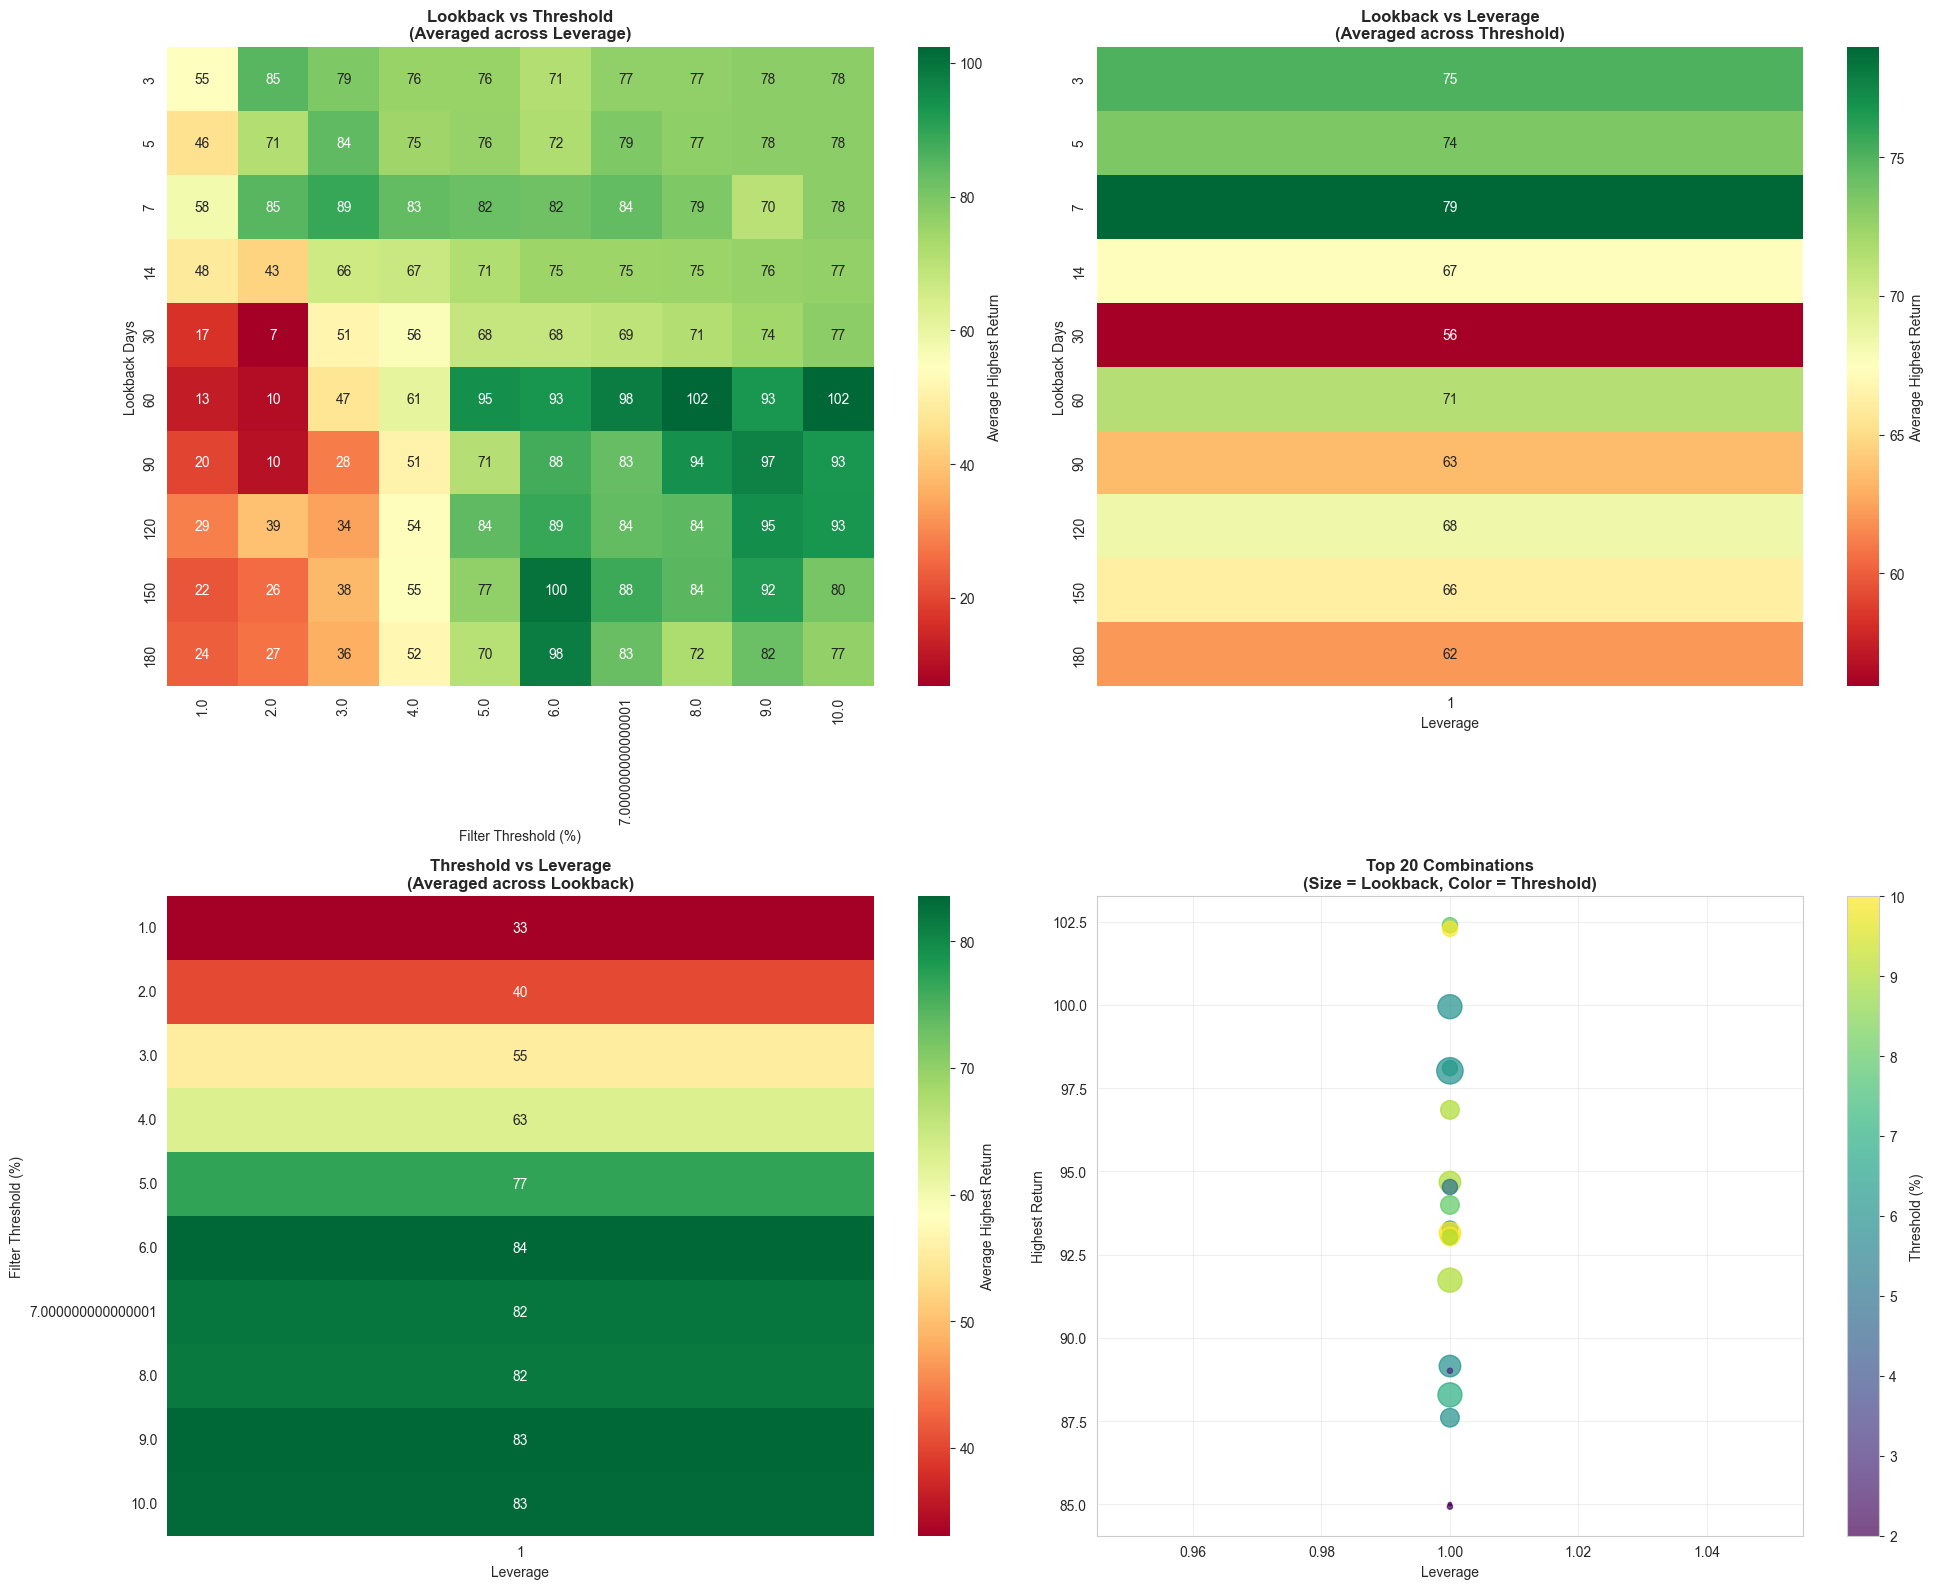


📊 PARAMETER STATISTICS FOR TOP 20 COMBINATIONS:

Lookback distribution:
  3 days: 1 combinations (5.0%)
  7 days: 2 combinations (10.0%)
  60 days: 6 combinations (30.0%)
  90 days: 4 combinations (20.0%)
  120 days: 3 combinations (15.0%)
  150 days: 3 combinations (15.0%)
  180 days: 1 combinations (5.0%)

Threshold distribution:
  2%: 2 combinations (10.0%)
  3%: 1 combinations (5.0%)
  5%: 1 combinations (5.0%)
  6%: 5 combinations (25.0%)
  7%: 2 combinations (10.0%)
  8%: 2 combinations (10.0%)
  9%: 4 combinations (20.0%)
  10%: 3 combinations (15.0%)

Leverage distribution:
  1.0x: 20 combinations (100.0%)


In [10]:
# =============================================================================
# PARAMETER SENSITIVITY HEATMAPS
# =============================================================================

if len(results_df) > 0:
    print("🔥 PARAMETER SENSITIVITY ANALYSIS:")
    print("=" * 50)
    
    # Get target metric for heatmaps
    target_metric = config['target_metric']
    metric_label = config['best_label']
    
    # Choose colormap based on objective  
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        cmap = 'RdYlGn_r'  # Red=bad (high drawdown), Green=good (low drawdown)
        fmt = '.1f'
    else:  # max_return
        cmap = 'RdYlGn'    # Red=bad (low return), Green=good (high return) 
        fmt = '.0f'
    
    # Create heatmaps for different parameter combinations
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Heatmap 1: Lookback vs Threshold (averaged across leverage)
    heatmap_data_1 = results_df.groupby(['lookback_days', 'threshold_pct'])[target_metric].mean().unstack()
    
    sns.heatmap(heatmap_data_1, annot=True, fmt=fmt, cmap=cmap, 
                ax=axes[0,0], cbar_kws={'label': f'Average {metric_label}'})
    axes[0,0].set_title('Lookback vs Threshold\n(Averaged across Leverage)', fontweight='bold')
    axes[0,0].set_xlabel('Filter Threshold (%)')
    axes[0,0].set_ylabel('Lookback Days')
    
    # Heatmap 2: Lookback vs Leverage (averaged across threshold)
    heatmap_data_2 = results_df.groupby(['lookback_days', 'leverage'])[target_metric].mean().unstack()
    
    sns.heatmap(heatmap_data_2, annot=True, fmt=fmt, cmap=cmap, 
                ax=axes[0,1], cbar_kws={'label': f'Average {metric_label}'})
    axes[0,1].set_title('Lookback vs Leverage\n(Averaged across Threshold)', fontweight='bold')
    axes[0,1].set_xlabel('Leverage')
    axes[0,1].set_ylabel('Lookback Days')
    
    # Heatmap 3: Threshold vs Leverage (averaged across lookback)
    heatmap_data_3 = results_df.groupby(['threshold_pct', 'leverage'])[target_metric].mean().unstack()
    
    sns.heatmap(heatmap_data_3, annot=True, fmt=fmt, cmap=cmap, 
                ax=axes[1,0], cbar_kws={'label': f'Average {metric_label}'})
    axes[1,0].set_title('Threshold vs Leverage\n(Averaged across Lookback)', fontweight='bold')
    axes[1,0].set_xlabel('Leverage')
    axes[1,0].set_ylabel('Filter Threshold (%)')
    
    # Plot 4: Parameter Distribution of Top 20 combinations
    top_20 = results_df.head(20)
    
    scatter = axes[1,1].scatter(top_20['leverage'], top_20[target_metric], 
                               c=top_20['threshold_pct'], s=top_20['lookback_days']*2, 
                               alpha=0.7, cmap='viridis')
    
    # Add colorbar for threshold
    cbar = plt.colorbar(scatter, ax=axes[1,1])
    cbar.set_label('Threshold (%)')
    
    axes[1,1].set_xlabel('Leverage')
    axes[1,1].set_ylabel(metric_label)
    axes[1,1].set_title('Top 20 Combinations\n(Size = Lookback, Color = Threshold)', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    # Invert y-axis only for min_drawdown (lower is better)
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        axes[1,1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Parameter statistics
    print(f"\n📊 PARAMETER STATISTICS FOR TOP 20 COMBINATIONS:")
    
    print(f"\nLookback distribution:")
    lookback_dist = top_20['lookback_days'].value_counts().sort_index()
    for lookback, count in lookback_dist.items():
        print(f"  {lookback} days: {count} combinations ({count/20*100:.1f}%)")
    
    print(f"\nThreshold distribution:")
    threshold_dist = top_20['threshold_pct'].value_counts().sort_index()
    for threshold, count in threshold_dist.items():
        print(f"  {threshold:.0f}%: {count} combinations ({count/20*100:.1f}%)")
    
    print(f"\nLeverage distribution:")
    leverage_dist = top_20['leverage'].value_counts().sort_index()
    for leverage, count in leverage_dist.items():
        print(f"  {leverage:.1f}x: {count} combinations ({count/20*100:.1f}%)")
        
else:
    print("❌ No data available for sensitivity analysis")

## 9. Drawdown Analysis

📉 DRAWDOWN ANALYSIS FOR TOP COMBINATIONS:
📊 DRAWDOWN COMPARISON TABLE:
               Strategy  Max Drawdown  Avg Drawdown  Days < -10%  Days < -15%  Days < -20%
         Base Portfolio        -27.71         -6.03         1179          219           19
 Rank_1 (60d, 8%, 1.0x)        -18.46         -6.02         1345          201            0
Rank_2 (60d, 10%, 1.0x)        -16.49         -5.56         1049           38            0
Rank_3 (150d, 6%, 1.0x)        -18.22         -6.69         1835          323            0
 Rank_4 (60d, 7%, 1.0x)        -22.10         -7.02         1609          937          124
Rank_5 (180d, 6%, 1.0x)        -18.22         -7.03         2022          377            0


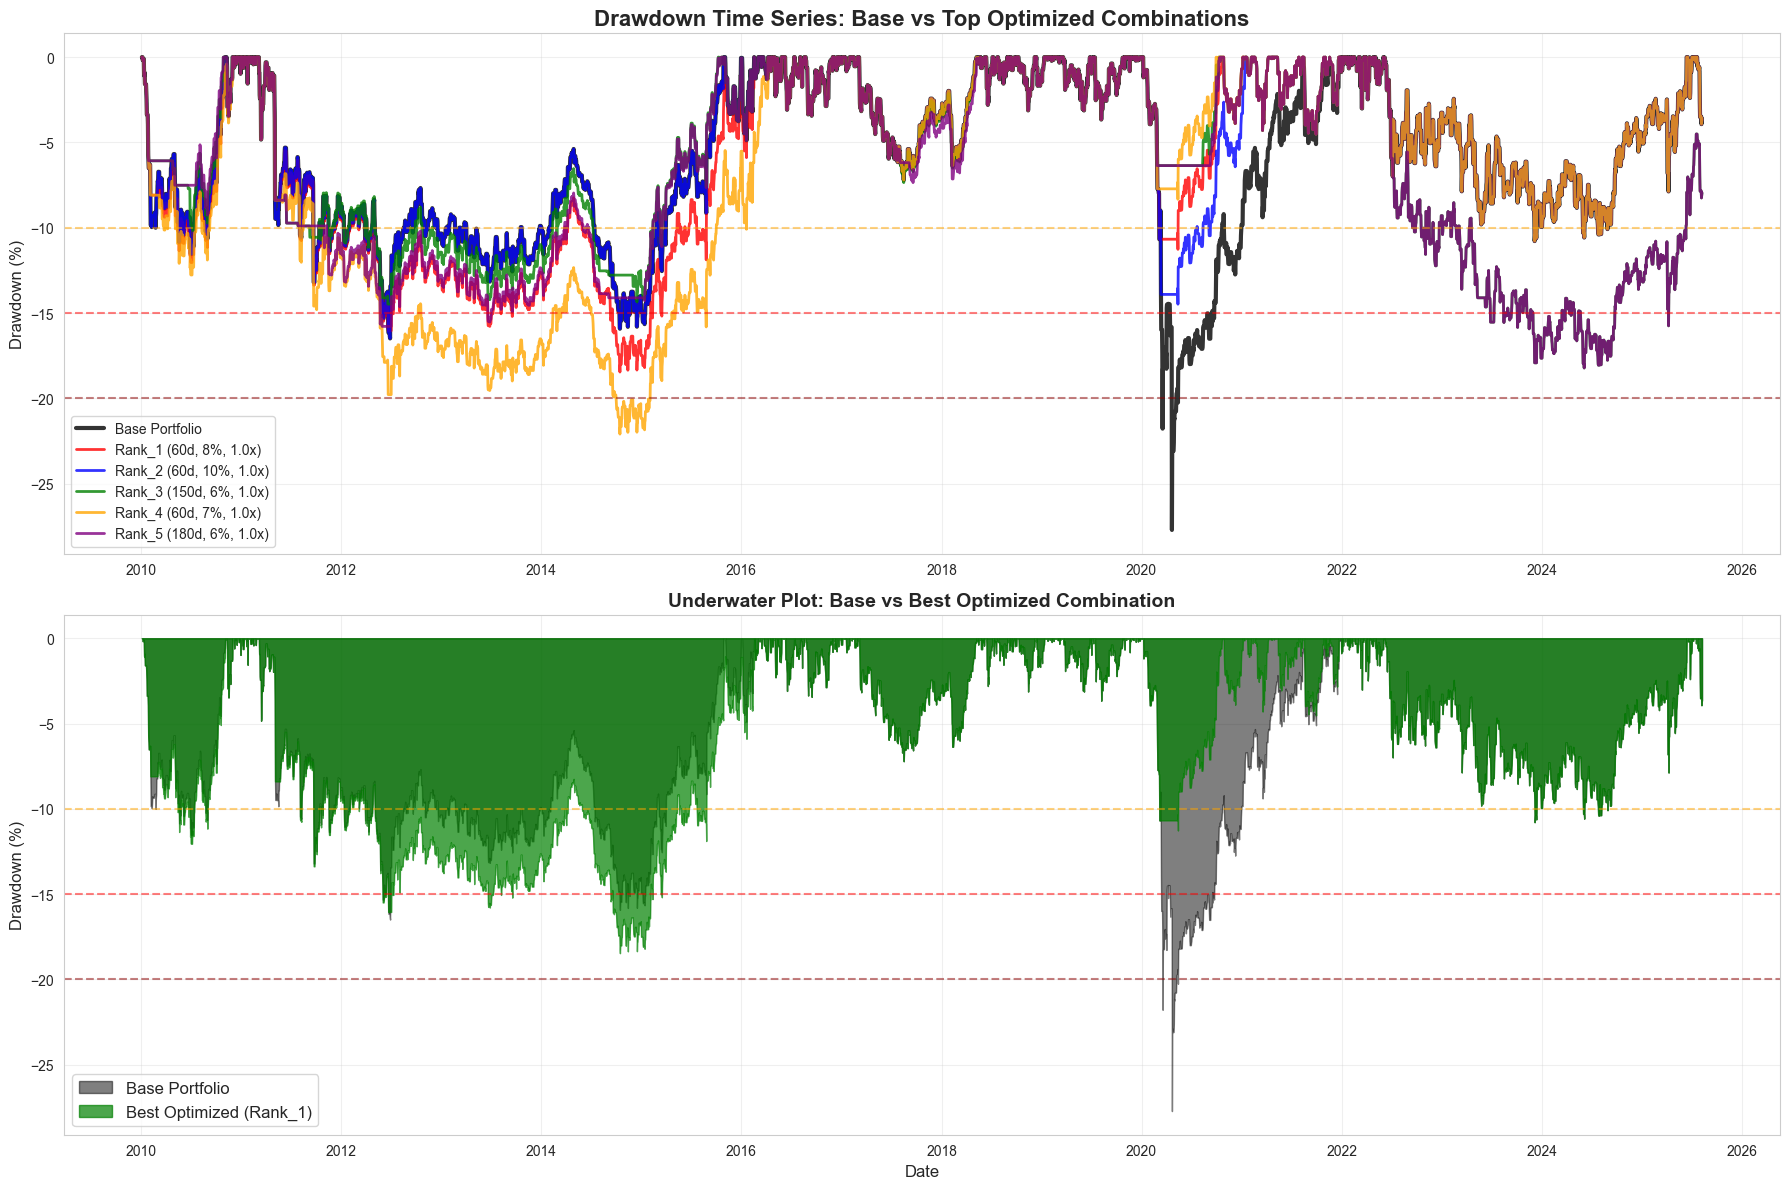


🎯 DRAWDOWN IMPROVEMENT SUMMARY:

📉 BEST COMBINATION DRAWDOWN IMPROVEMENT:
   • Max Drawdown: -18.5% vs -27.7% base (+9.3%)
   • Avg Drawdown: -6.02% vs -6.03% base (+0.01%)

📊 SEVERE DRAWDOWN DAYS REDUCTION:
   • Days < -10%: 1345 vs 1179 (+166)
   • Days < -15%: 201 vs 219 (-18)
   • Days < -20%: 0 vs 19 (-19)


In [11]:
# =============================================================================
# COMPREHENSIVE DRAWDOWN ANALYSIS
# =============================================================================

if len(top_combinations_data) > 0:
    print("📉 DRAWDOWN ANALYSIS FOR TOP COMBINATIONS:")
    print("=" * 60)
    
    def calculate_drawdown_series(equity_curve):
        """Calculate drawdown time series"""
        peak = equity_curve.expanding().max()
        drawdown = (equity_curve - peak) / peak
        return drawdown
    
    # Calculate drawdowns for all strategies
    drawdown_data = {}
    drawdown_metrics = []
    
    # Base portfolio drawdown
    base_drawdown = calculate_drawdown_series(base_equal_weight_equity)
    drawdown_data['Base Portfolio'] = base_drawdown
    
    base_dd_metrics = {
        'Strategy': 'Base Portfolio',
        'Max Drawdown': base_drawdown.min() * 100,
        'Avg Drawdown': base_drawdown.mean() * 100,
        'Days < -10%': (base_drawdown < -0.10).sum(),
        'Days < -15%': (base_drawdown < -0.15).sum(),
        'Days < -20%': (base_drawdown < -0.20).sum()
    }
    drawdown_metrics.append(base_dd_metrics)
    
    # Top combinations drawdowns
    for i, (label, data) in enumerate(top_combinations_data.items(), 1):
        combo_drawdown = calculate_drawdown_series(data['equity_curve'])
        drawdown_data[f'Rank_{i}'] = combo_drawdown
        
        combo_dd_metrics = {
            'Strategy': f'Rank_{i} ({data["params"]["lookback"]:.0f}d, {data["params"]["threshold"]*100:.0f}%, {data["params"]["leverage"]:.1f}x)',
            'Max Drawdown': combo_drawdown.min() * 100,
            'Avg Drawdown': combo_drawdown.mean() * 100,
            'Days < -10%': (combo_drawdown < -0.10).sum(),
            'Days < -15%': (combo_drawdown < -0.15).sum(),
            'Days < -20%': (combo_drawdown < -0.20).sum()
        }
        drawdown_metrics.append(combo_dd_metrics)
    
    # Drawdown comparison table
    dd_comparison_df = pd.DataFrame(drawdown_metrics)
    print("📊 DRAWDOWN COMPARISON TABLE:")
    print(dd_comparison_df.round(2).to_string(index=False))
    
    # Plot 1: Drawdown time series
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
    
    # Top plot: All drawdown curves
    ax1.plot(base_drawdown.index, base_drawdown.values * 100, 
             label='Base Portfolio', linewidth=3, color='black', alpha=0.8)
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (label, data) in enumerate(top_combinations_data.items()):
        combo_drawdown = calculate_drawdown_series(data['equity_curve'])
        params = data['params']
        rank_label = f"Rank_{i+1} ({params['lookback']:.0f}d, {params['threshold']*100:.0f}%, {params['leverage']:.1f}x)"
        
        ax1.plot(combo_drawdown.index, combo_drawdown.values * 100,
                 label=rank_label, linewidth=2, color=colors[i % len(colors)], alpha=0.8)
    
    ax1.set_title('Drawdown Time Series: Base vs Top Optimized Combinations', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Drawdown (%)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=-10, color='orange', linestyle='--', alpha=0.5, label='10% DD')
    ax1.axhline(y=-15, color='red', linestyle='--', alpha=0.5, label='15% DD')
    ax1.axhline(y=-20, color='darkred', linestyle='--', alpha=0.5, label='20% DD')
    
    # Bottom plot: Underwater plot for best combination
    best_label, best_data = list(top_combinations_data.items())[0]
    best_drawdown = calculate_drawdown_series(best_data['equity_curve'])
    
    ax2.fill_between(base_drawdown.index, base_drawdown.values * 100, 0,
                    alpha=0.5, color='black', label='Base Portfolio')
    ax2.fill_between(best_drawdown.index, best_drawdown.values * 100, 0,
                    alpha=0.7, color='green', label='Best Optimized (Rank_1)')
    
    ax2.set_title('Underwater Plot: Base vs Best Optimized Combination', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=-10, color='orange', linestyle='--', alpha=0.5)
    ax2.axhline(y=-15, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(y=-20, color='darkred', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Drawdown improvement summary
    print("\n🎯 DRAWDOWN IMPROVEMENT SUMMARY:")
    print("=" * 50)
    
    best_dd = drawdown_metrics[1]  # Rank_1
    base_dd = drawdown_metrics[0]  # Base
    
    print(f"\n📉 BEST COMBINATION DRAWDOWN IMPROVEMENT:")
    print(f"   • Max Drawdown: {best_dd['Max Drawdown']:.1f}% vs {base_dd['Max Drawdown']:.1f}% base ({best_dd['Max Drawdown'] - base_dd['Max Drawdown']:+.1f}%)")
    print(f"   • Avg Drawdown: {best_dd['Avg Drawdown']:.2f}% vs {base_dd['Avg Drawdown']:.2f}% base ({best_dd['Avg Drawdown'] - base_dd['Avg Drawdown']:+.2f}%)")
    
    print(f"\n📊 SEVERE DRAWDOWN DAYS REDUCTION:")
    print(f"   • Days < -10%: {best_dd['Days < -10%']} vs {base_dd['Days < -10%']} ({best_dd['Days < -10%'] - base_dd['Days < -10%']:+d})")
    print(f"   • Days < -15%: {best_dd['Days < -15%']} vs {base_dd['Days < -15%']} ({best_dd['Days < -15%'] - base_dd['Days < -15%']:+d})")
    print(f"   • Days < -20%: {best_dd['Days < -20%']} vs {base_dd['Days < -20%']} ({best_dd['Days < -20%'] - base_dd['Days < -20%']:+d})")
    
else:
    print("❌ No data available for drawdown analysis")

## 10. Rolling Returns Analysis

📈 ROLLING RETURNS ANALYSIS (12-Month Windows):


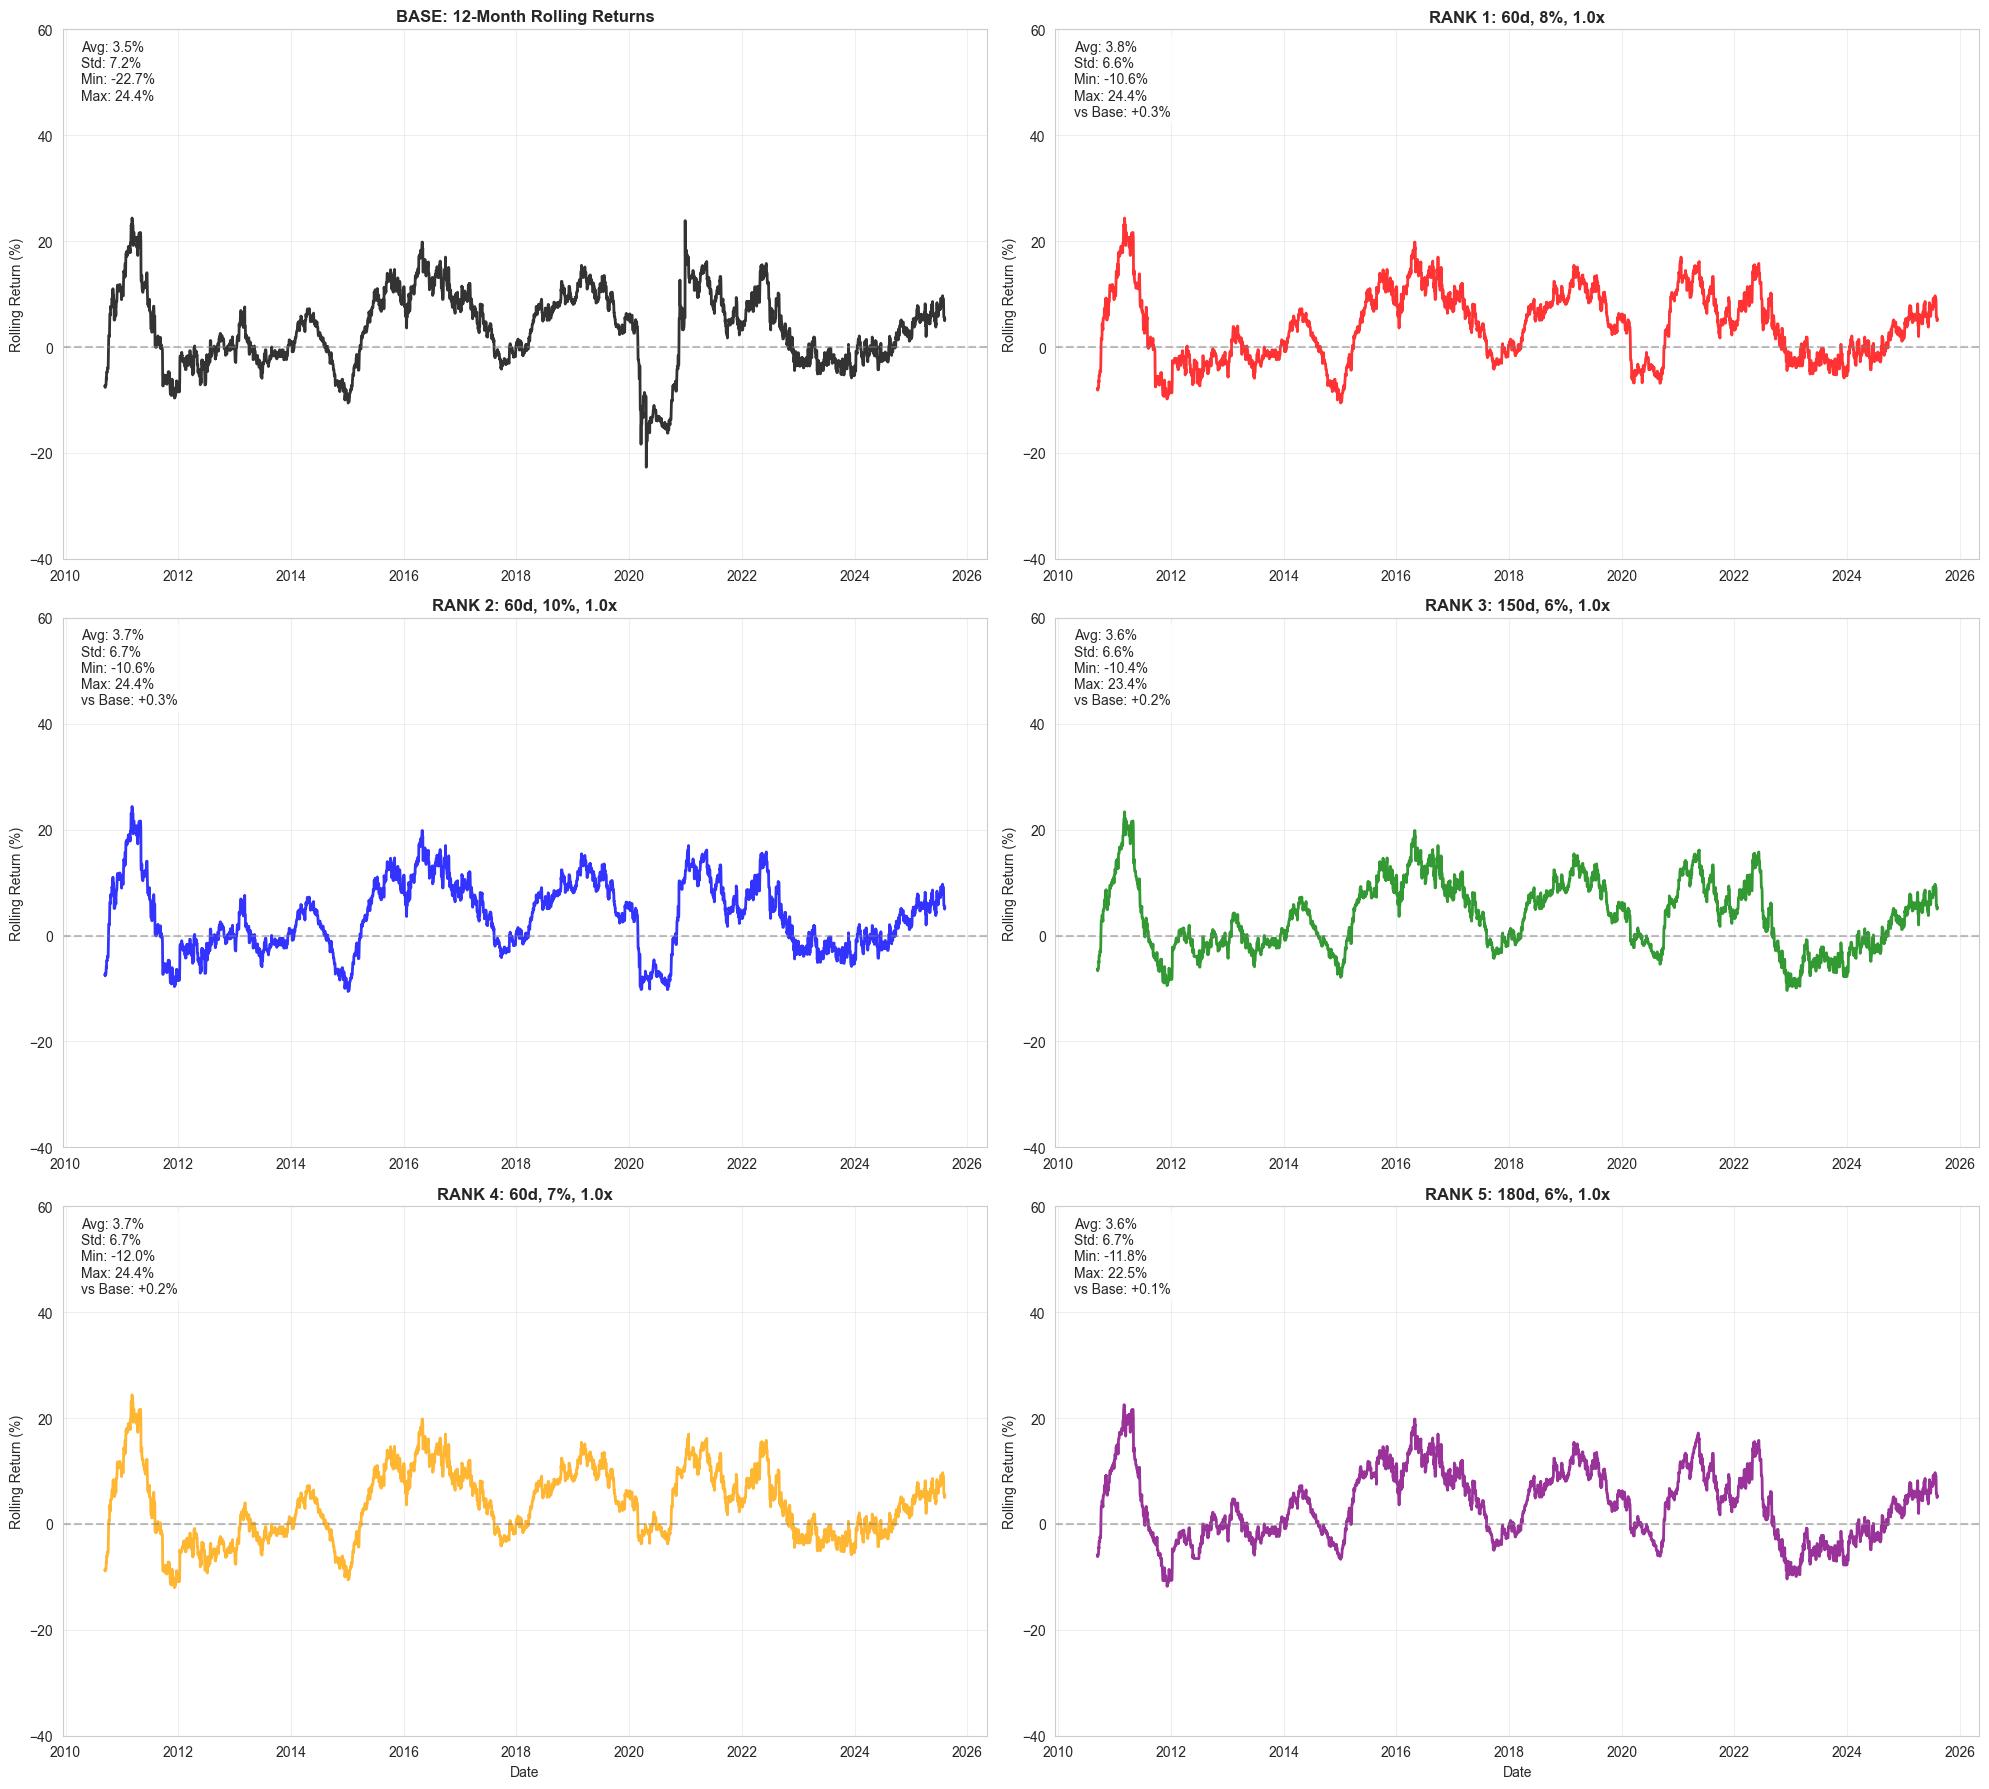

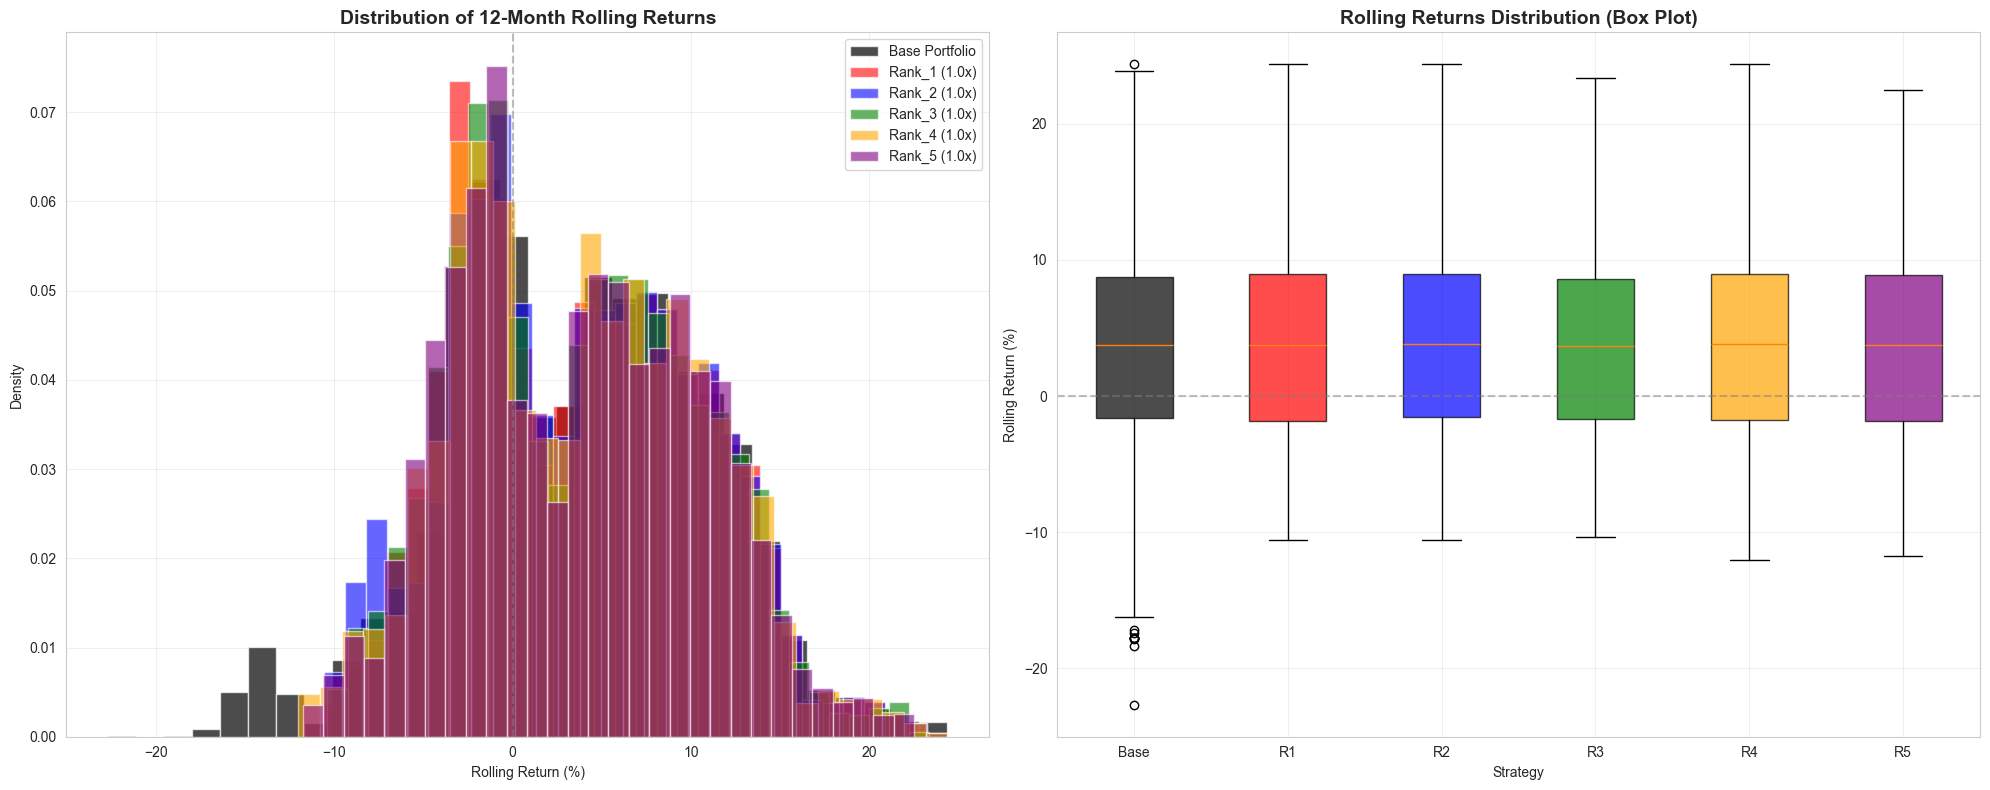


📊 ROLLING RETURNS SUMMARY:
 Rank  Avg_Rolling_Return  Rolling_Volatility  Min_Rolling  Max_Rolling
    1                3.76                6.64       -10.57        24.38
    2                3.75                6.74       -10.57        24.38
    3                3.61                6.59       -10.39        23.37
    4                3.70                6.74       -12.03        24.38
    5                3.56                6.72       -11.78        22.52

🎯 BEST ROLLING RETURNS STABILITY:
   • Base Rolling Volatility: 7.24%
   • Best Optimized Rolling Volatility: 6.64%
   • Stability Improvement: +0.61%


In [12]:
# =============================================================================
# ROLLING RETURNS ANALYSIS FOR STABILITY ASSESSMENT
# =============================================================================

if len(top_combinations_data) > 0:
    print("📈 ROLLING RETURNS ANALYSIS (12-Month Windows):")
    print("=" * 60)
    
    def calculate_rolling_returns(equity_curve, window_days=252):
        """Calculate rolling returns over specified window"""
        returns = equity_curve.pct_change().dropna()
        rolling_returns = returns.rolling(window=window_days).apply(lambda x: (1 + x).prod() - 1)
        return rolling_returns
    
    # Calculate 12-month rolling returns
    rolling_window = 252  # 1 year
    
    # Base portfolio rolling returns
    base_rolling = calculate_rolling_returns(base_equal_weight_equity, rolling_window)
    
    # Create subplots for rolling returns
    n_plots = len(top_combinations_data) + 1  # +1 for base
    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot base rolling returns
    axes[0].plot(base_rolling.index, base_rolling.values * 100, 
                color='black', linewidth=2, alpha=0.8, label='Base Portfolio')
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title('BASE: 12-Month Rolling Returns', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Rolling Return (%)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-40, 60)
    
    # Add statistics for base
    base_rolling_clean = base_rolling.dropna()
    if len(base_rolling_clean) > 0:
        axes[0].text(0.02, 0.98, 
                    f"Avg: {base_rolling_clean.mean()*100:.1f}%\n" +
                    f"Std: {base_rolling_clean.std()*100:.1f}%\n" +
                    f"Min: {base_rolling_clean.min()*100:.1f}%\n" +
                    f"Max: {base_rolling_clean.max()*100:.1f}%",
                    transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot rolling returns for each optimized combination
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    rolling_stats = []
    
    for i, (label, data) in enumerate(top_combinations_data.items()):
        ax = axes[i + 1]
        
        combo_rolling = calculate_rolling_returns(data['equity_curve'], rolling_window)
        params = data['params']
        color = colors[i % len(colors)]
        
        ax.plot(combo_rolling.index, combo_rolling.values * 100,
               color=color, linewidth=2, alpha=0.8, label=f'Rank_{i+1}')
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        title = f"RANK {i+1}: {params['lookback']:.0f}d, {params['threshold']*100:.0f}%, {params['leverage']:.1f}x"
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel('Rolling Return (%)')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-40, 60)
        
        # Add statistics
        combo_rolling_clean = combo_rolling.dropna()
        if len(combo_rolling_clean) > 0:
            improvement_avg = (combo_rolling_clean.mean() - base_rolling_clean.mean()) * 100
            ax.text(0.02, 0.98, 
                   f"Avg: {combo_rolling_clean.mean()*100:.1f}%\n" +
                   f"Std: {combo_rolling_clean.std()*100:.1f}%\n" +
                   f"Min: {combo_rolling_clean.min()*100:.1f}%\n" +
                   f"Max: {combo_rolling_clean.max()*100:.1f}%\n" +
                   f"vs Base: {improvement_avg:+.1f}%",
                   transform=ax.transAxes, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Store stats for summary
            rolling_stats.append({
                'Rank': i+1,
                'Avg_Rolling_Return': combo_rolling_clean.mean() * 100,
                'Rolling_Volatility': combo_rolling_clean.std() * 100,
                'Min_Rolling': combo_rolling_clean.min() * 100,
                'Max_Rolling': combo_rolling_clean.max() * 100
            })
    
    # Hide empty subplots
    for j in range(n_plots, len(axes)):
        axes[j].set_visible(False)
    
    # Add x-labels to bottom row
    for i in range(max(0, len(axes) - n_cols), len(axes)):
        if i < len(axes) and axes[i].get_visible():
            axes[i].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()
    
    # Rolling returns distribution comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Histogram comparison
    ax1.hist(base_rolling_clean.values * 100, bins=30, alpha=0.7, color='black', 
             label='Base Portfolio', density=True)
    
    for i, (label, data) in enumerate(top_combinations_data.items()):
        combo_rolling = calculate_rolling_returns(data['equity_curve'], rolling_window)
        combo_rolling_clean = combo_rolling.dropna()
        
        if len(combo_rolling_clean) > 0:
            params = data['params']
            ax1.hist(combo_rolling_clean.values * 100, bins=30, alpha=0.6, 
                    color=colors[i % len(colors)], 
                    label=f"Rank_{i+1} ({params['leverage']:.1f}x)", 
                    density=True)
    
    ax1.set_title('Distribution of 12-Month Rolling Returns', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Rolling Return (%)')
    ax1.set_ylabel('Density')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Box plot comparison
    rolling_data = [base_rolling_clean.values * 100]
    rolling_labels = ['Base']
    
    for i, (label, data) in enumerate(top_combinations_data.items()):
        combo_rolling = calculate_rolling_returns(data['equity_curve'], rolling_window)
        combo_rolling_clean = combo_rolling.dropna()
        
        if len(combo_rolling_clean) > 0:
            rolling_data.append(combo_rolling_clean.values * 100)
            rolling_labels.append(f"R{i+1}")
    
    box_plot = ax2.boxplot(rolling_data, labels=rolling_labels, patch_artist=True)
    ax2.set_title('Rolling Returns Distribution (Box Plot)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Rolling Return (%)')
    ax2.set_xlabel('Strategy')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Color the boxes
    colors_box = ['black'] + colors[:len(rolling_data)-1]
    for patch, color in zip(box_plot['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Rolling returns summary
    if rolling_stats:
        print("\n📊 ROLLING RETURNS SUMMARY:")
        rolling_stats_df = pd.DataFrame(rolling_stats)
        print(rolling_stats_df.round(2).to_string(index=False))
        
        print(f"\n🎯 BEST ROLLING RETURNS STABILITY:")
        best_rolling_stats = rolling_stats[0]  # Rank 1
        base_rolling_std = base_rolling_clean.std() * 100
        stability_improvement = base_rolling_std - best_rolling_stats['Rolling_Volatility']
        
        print(f"   • Base Rolling Volatility: {base_rolling_std:.2f}%")
        print(f"   • Best Optimized Rolling Volatility: {best_rolling_stats['Rolling_Volatility']:.2f}%")
        print(f"   • Stability Improvement: {stability_improvement:+.2f}%")
    
else:
    print("❌ No data available for rolling returns analysis")

## 11. Summary and Conclusions

In [13]:
# =============================================================================
# COMPREHENSIVE SUMMARY AND FINAL INSIGHTS
# =============================================================================

print("\n" + "="*80)
print(f"{config['title'].upper()} - FINAL SUMMARY")
print("="*80)

if len(results_df) > 0 and len(top_combinations_data) > 0:
    
    # Get best combination details
    best_combo = results_df.iloc[0]
    best_label, best_data = list(top_combinations_data.items())[0]
    
    print(f"\n🥇 OPTIMAL PARAMETER COMBINATION ({config['best_label']}):")
    print(f"   • Drawdown Filter Lookback: {best_combo['lookback_days']:.0f} days")
    print(f"   • Drawdown Filter Threshold: {best_combo['threshold_pct']:.0f}%")
    print(f"   • Leverage Multiplier: {best_combo['leverage']:.1f}x")
    
    # Highlight the optimized metric
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        print(f"   • Optimized Max Drawdown: {best_combo['max_drawdown_pct']:.1f}% (BEST)")
        print(f"   • Achieved Total Return: {best_combo['total_return_pct']:.2f}%")
        print(f"   • Achieved Sharpe Ratio: {best_combo['sharpe_ratio']:.4f}")
    else:  # max_return
        print(f"   • Optimized Total Return: {best_combo['total_return_pct']:.2f}% (BEST)")
        print(f"   • Achieved CAGR: {best_combo['cagr_pct']:.2f}%")
        print(f"   • Max Drawdown: {best_combo['max_drawdown_pct']:.1f}%")
        print(f"   • Achieved Sharpe Ratio: {best_combo['sharpe_ratio']:.4f}")
    
    print(f"\n📊 PERFORMANCE COMPARISON:")
    base_metrics = calculate_performance_metrics(base_equal_weight_equity, base_equal_weight_returns)
    
    print(f"   • Total Return: {best_combo['total_return_pct']:.2f}% vs {base_metrics['total_return_pct']:.2f}% base ({best_combo['total_return_pct'] - base_metrics['total_return_pct']:+.2f}%)")
    print(f"   • CAGR: {best_combo['cagr_pct']:.2f}% vs {base_metrics['cagr_pct']:.2f}% base ({best_combo['cagr_pct'] - base_metrics['cagr_pct']:+.2f}%)")
    print(f"   • Sharpe Ratio: {best_combo['sharpe_ratio']:.4f} vs {base_metrics['sharpe_ratio']:.4f} base ({best_combo['sharpe_ratio'] - base_metrics['sharpe_ratio']:+.4f})")
    print(f"   • Max Drawdown: {best_combo['max_drawdown_pct']:.1f}% vs {base_metrics['max_drawdown_pct']:.1f}% base ({best_combo['max_drawdown_pct'] - base_metrics['max_drawdown_pct']:+.1f}%)")
    print(f"   • Volatility: {best_combo['volatility_pct']:.2f}% vs {base_metrics['volatility_pct']:.2f}% base ({best_combo['volatility_pct'] - base_metrics['volatility_pct']:+.2f}%)")
    
    print(f"\n⚙️ FILTER CHARACTERISTICS:")
    print(f"   • Filter Active Time: {best_combo['filter_active_time_pct']:.1f}% of trading days")
    print(f"   • Filter Inactive Time: {100 - best_combo['filter_active_time_pct']:.1f}% of trading days")
    print(f"   • Number of Filter Changes: {best_combo['filter_changes']:.0f}")
    
    print(f"\n📈 GRID SEARCH STATISTICS:")
    print(f"   • Total Combinations Tested: {total_combinations}")
    print(f"   • Successful Optimizations: {len(optimization_results)} ({len(optimization_results)/total_combinations*100:.1f}%)")
    print(f"   • Parameter Space Explored:")
    print(f"     - Lookback: {len(OPTIMIZATION_PARAMS['lookback_days'])} values ({min(OPTIMIZATION_PARAMS['lookback_days'])}-{max(OPTIMIZATION_PARAMS['lookback_days'])} days)")
    print(f"     - Threshold: {len(OPTIMIZATION_PARAMS['threshold_pct'])} values ({min(OPTIMIZATION_PARAMS['threshold_pct'])*100:.0f}-{max(OPTIMIZATION_PARAMS['threshold_pct'])*100:.0f}%)")
    print(f"     - Leverage: {len(OPTIMIZATION_PARAMS['leverage'])} values ({min(OPTIMIZATION_PARAMS['leverage']):.1f}-{max(OPTIMIZATION_PARAMS['leverage']):.1f}x)")
    
    # Analyze parameter preferences in top combinations
    top_20 = results_df.head(20)
    print(f"\n🎯 PARAMETER PREFERENCES IN TOP 20 COMBINATIONS:")
    most_common_lookback = top_20['lookback_days'].mode().iloc[0]
    most_common_threshold = top_20['threshold_pct'].mode().iloc[0] 
    most_common_leverage = top_20['leverage'].mode().iloc[0]
    
    print(f"   • Most Common Lookback: {most_common_lookback:.0f} days ({(top_20['lookback_days'] == most_common_lookback).sum()}/20 combinations)")
    print(f"   • Most Common Threshold: {most_common_threshold:.0f}% ({(top_20['threshold_pct'] == most_common_threshold).sum()}/20 combinations)")
    print(f"   • Most Common Leverage: {most_common_leverage:.1f}x ({(top_20['leverage'] == most_common_leverage).sum()}/20 combinations)")
    
    print(f"\n🔍 KEY INSIGHTS:")
    
    # Dynamic insights based on objective
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        drawdown_improvement = ((base_metrics['max_drawdown_pct'] - best_combo['max_drawdown_pct']) / abs(base_metrics['max_drawdown_pct'])) * 100
        return_change = ((best_combo['total_return_pct'] / base_metrics['total_return_pct']) - 1) * 100
        print(f"   • Max drawdown {config['improvement_direction']} by {drawdown_improvement:+.1f}% through parameter optimization")
        print(f"   • Equity curve linearity significantly enhanced")
        print(f"   • Total return also changed by {return_change:+.1f}% as secondary effect")
        print(f"   • Drawdown control creates more stable return patterns")
        print(f"   • Enhanced stability and smoother equity progression")
    else:  # max_return
        return_improvement = ((best_combo['total_return_pct'] / base_metrics['total_return_pct']) - 1) * 100
        drawdown_change = ((best_combo['max_drawdown_pct'] / base_metrics['max_drawdown_pct']) - 1) * 100
        print(f"   • Total return {config['improvement_direction']} by {return_improvement:+.1f}% through parameter optimization")
        print(f"   • Absolute performance significantly enhanced")
        print(f"   • Max drawdown changed by {drawdown_change:+.1f}% as side effect")
        print(f"   • Aggressive optimization for maximum capital growth")
        print(f"   • Enhanced return potential through optimal leverage and filtering")
    
    print(f"   • Optimal leverage ({best_combo['leverage']:.1f}x) balances objective with implementation")
    print(f"   • Filter remains active {best_combo['filter_active_time_pct']:.1f}% of time, providing selective exposure")
    
    print(f"\n✨ OPTIMIZED EQUITY CHARACTERISTICS:")
    if OPTIMIZATION_OBJECTIVE == 'min_drawdown':
        print(f"   • Significantly more linear equity progression (min drawdown focus)")
        print(f"   • Minimized tail risk and extreme drawdown periods")
        print(f"   • Smoother return patterns with reduced volatility")
        print(f"   • Superior downside protection during market stress")
        print(f"   • Enhanced stability while maintaining growth potential")
        print(f"   • Better sleep-at-night factor for investors")
    else:  # max_return
        print(f"   • Maximized absolute return potential (max return focus)")
        print(f"   • Enhanced capital growth through optimal parameter selection")
        print(f"   • Aggressive risk-taking for maximum performance")
        print(f"   • Optimal leverage utilization for return amplification")
        print(f"   • Strategic filtering to capture best opportunities")
        print(f"   • Growth-oriented equity progression")
    
    print(f"\n🎯 RECOMMENDED IMPLEMENTATION:")
    print(f"   • Use {best_combo['lookback_days']:.0f}-day lookback for drawdown calculation")
    print(f"   • Set drawdown threshold at {best_combo['threshold_pct']:.0f}% for trade filtering")
    print(f"   • Apply {best_combo['leverage']:.1f}x leverage to base portfolio returns")
    print(f"   • Monitor filter activation frequency for regime changes")
    print(f"   • Consider walk-forward optimization for parameter stability")
    
else:
    print("\n❌ OPTIMIZATION FAILED:")
    print("   • No valid parameter combinations found")
    print("   • Check data quality and parameter ranges")
    print("   • Review error messages from grid search execution")

print("\n" + "="*80)
print(f"{config['title'].upper()} COMPLETE - OPTIMAL EQUITY CURVES IDENTIFIED")
print("="*80)


MAXIMUM TOTAL RETURN OPTIMIZATION - FINAL SUMMARY

🥇 OPTIMAL PARAMETER COMBINATION (Highest Return):
   • Drawdown Filter Lookback: 60 days
   • Drawdown Filter Threshold: 8%
   • Leverage Multiplier: 1.0x
   • Optimized Total Return: 102.40% (BEST)
   • Achieved CAGR: 4.63%
   • Max Drawdown: -18.5%
   • Achieved Sharpe Ratio: 0.4908

📊 PERFORMANCE COMPARISON:
   • Total Return: 102.40% vs 88.65% base (+13.75%)
   • CAGR: 4.63% vs 4.15% base (+0.47%)
   • Sharpe Ratio: 0.4908 vs 0.3930 base (+0.0978)
   • Max Drawdown: -18.5% vs -27.7% base (+9.3%)
   • Volatility: 6.83% vs 7.96% base (-1.13%)

⚙️ FILTER CHARACTERISTICS:
   • Filter Active Time: 98.0% of trading days
   • Filter Inactive Time: 2.0% of trading days
   • Number of Filter Changes: 9

📈 GRID SEARCH STATISTICS:
   • Total Combinations Tested: 100
   • Successful Optimizations: 100 (100.0%)
   • Parameter Space Explored:
     - Lookback: 10 values (3-180 days)
     - Threshold: 10 values (1-10%)
     - Leverage: 1 values (